# XAI Analytics Notebook

In [1]:
import os
import xai
import logging as log 
import ipywidgets as widgets
import util.commons
import eli5
import random
import warnings
import matplotlib.pyplot as plt

from xai import imbalance_plot
from datetime import date
from util.commons import *
from util.ui import *
from util.model import *
from util.split import *
from util.dataset import *
from ipywidgets import interact, interact_manual, interactive, interactive_output
from ipywidgets import Button, GridBox, Layout, ButtonStyle, Label
from IPython.display import clear_output

shap.initjs()
%matplotlib inline
plt.style.use('ggplot')
warnings.filterwarnings('ignore')

/home/g3no/github/XAI-Analytics/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/g3no/github/XAI-Analytics/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


Select the dataset that you would like to invastigate later with the help of the available interpretability tools.

In [15]:
dataset_select_label = Label(layout=Layout(width='auto', height='auto'), value='Select a dataset (you can specify custom one by selecting other):')
dataset_select_dropdown = widgets.Dropdown(options=[m.name for m in Datasets], value=None, layout=Layout(width='200px', height='auto'))
name_url_text_label = Label(value='Provide dataset name and URL:')
name_text = widgets.Text(description='Name: ', placeholder='e.g. Car Evaluation Data Set', disabled=True)
url_text = widgets.Text(description='URL: ', placeholder='e.g. https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data', disabled=True)
dataset_select_button = widgets.Button(description='Download dataset', layout=Layout(width='300px', height='auto'), style=ButtonStyle(button_color='green'), tooltip='Click me', icon='download', disabled=True)
dataset_select_output = widgets.Output()

display(dataset_select_label,
        dataset_select_dropdown,
        name_url_text_label,
        name_text,
        url_text,
        dataset_select_button,
        dataset_select_output)

def on_value_change_dataset_select_dropdown(change):
    dataset_select_output.clear_output()
    global dataset
    new_value = str(change['new'])
    if new_value == 'other':
        name_text.disabled=False
        url_text.disabled=False
        dataset_select_button.disabled=False
    else:
        name_text.disabled=True
        url_text.disabled=True
        dataset_select_button.disabled=True
        dataset, msg = get_dataset(new_value)
        with dataset_select_output:
            display(msg)
            
def on_click_dataset_select_button(self):
    dataset_select_output.clear_output()
    global dataset
    name = str(name_text.value)
    url = str(url_text.value)
    dataset, msg = get_dataset(name, url)
    with dataset_select_output:
        display(msg)

dataset_select_dropdown.observe(on_value_change_dataset_select_dropdown, names='value')
dataset_select_button.on_click(on_click_dataset_select_button)

Label(value='Select a dataset (you can specify custom one by selecting other):', layout=Layout(height='auto', …

Dropdown(layout=Layout(height='auto', width='200px'), options=('anes96', 'cancer', 'ccard', 'china_smoking', '…

Label(value='Provide dataset name and URL:')

Text(value='', description='Name: ', disabled=True, placeholder='e.g. Car Evaluation Data Set')

Text(value='', description='URL: ', disabled=True, placeholder='e.g. https://archive.ics.uci.edu/ml/machine-le…

Button(description='Download dataset', disabled=True, icon='download', layout=Layout(height='auto', width='300…

Output()

13-Jun-20 15:18:57 - Dataset 'census (Adult census dataset)' loaded successfully. For further information about this dataset please visit: https://ethicalml.github.io/xai/index.html?highlight=load_census#xai.data.load_census
13-Jun-20 15:18:57 - 
   age          workclass   education  education-num       marital-status  \
0   39          State-gov   Bachelors             13        Never-married   
1   50   Self-emp-not-inc   Bachelors             13   Married-civ-spouse   
2   38            Private     HS-grad              9             Divorced   
3   53            Private        11th              7   Married-civ-spouse   
4   28            Private   Bachelors             13   Married-civ-spouse   

           occupation    relationship ethnicity   gender  capital-gain  \
0        Adm-clerical   Not-in-family     White     Male          2174   
1     Exec-managerial         Husband     White     Male             0   
2   Handlers-cleaners   Not-in-family     White     Male            

In [14]:
from pandas.api.types import is_numeric_dtype, is_string_dtype

strip_column_select_label = Label(layout=Layout(width='auto', height='auto'), value='Strip a column from the dataset:')
strip_column_select_dropdown = widgets.Dropdown(options=list(dataset.df.columns), value=None, layout=Layout(width='220px', height='auto'))
strip_button = widgets.Button(disabled=False, style=ButtonStyle(button_color='yellow'), tooltip='Strips everything except the selected value.', icon='bolt', layout=Layout(width='max-content', height='auto'))
strip_column_output = widgets.Output()
strip_column_output_inner = widgets.Output()

# back up initial dataset
df_backup = dataset.df

#defaults for the cell
eq_value = '='
df_stripped = None

def on_value_change_strip_column_select_dropdown(change):
    strip_column_output.clear_output()
    strip_column_output_inner.clear_output()
    strip_button.description = ''
    new_value = str(change['new'])
    if is_numeric_dtype(dataset.df[new_value]):
        eq_radio = init_strip_eq_radio(on_value_change_eq_radio)
        min_val, max_val, step=calculate_slider_properties(dataset.df[new_value].unique())
        value_slider = init_strip_value_slider(on_value_change_value_slider, min_val, max_val, step)
        with strip_column_output:
            display(eq_radio, value_slider, strip_button, strip_column_output_inner)
    elif is_string_dtype(dataset.df[new_value]):
        value_select_dropdown = init_strip_value_select_dropdown(on_value_change_value_select_dropdown, list(dataset.df[new_value].unique()))
        with strip_column_output:
            display(value_select_dropdown, strip_button, strip_column_output_inner)
            
def on_value_change_value_select_dropdown(change):
    strip_column_output_inner.clear_output()
    global df_stripped
    new_value = str(change['new'])
    with strip_column_output_inner:
        strip_button.description='{} \'{}\''.format(strip_column_select_dropdown.value, new_value)
        df_stripped = get_stripped_df(dataset.df, strip_column_select_dropdown.value, new_value)
        display(df_stripped)

def on_value_change_value_slider(change):
    strip_column_output_inner.clear_output()
    global df_stripped
    new_value = float(str(change['new']))    
    with strip_column_output_inner:
        strip_button.description='{} {} \'{}\''.format(strip_column_select_dropdown.value, eq_value, new_value)
        df_stripped = get_stripped_df(dataset.df, strip_column_select_dropdown.value, new_value, eq_value)
        display(df_stripped)

def on_value_change_eq_radio(change):
    global eq_value
    eq_value = str(change['new'])
            
def on_click_strip_button(self):
    strip_column_output.clear_output()
    global stack_label, df_stripped
    dataset.df = df_stripped
    dataset.df.reset_index(drop=True, inplace=True)
    stack_label.value = stack_label.value + strip_button.description + ', ' 
    with strip_column_output:
        display('{} selected successfully.'.format(strip_button.description), dataset.df)
    
def on_click_reset_button(self):
    strip_column_output.clear_output()
    dataset.df = df_backup
    dataset.df.reset_index(drop=True, inplace=True)
    global stack_label
    stack_label.value = 'Stripped columns for the dataset: '
    with strip_column_output:
        display('Dataset restored to its initial state.', dataset.df)

hbox = generate_reset_strip_hbox(on_click_reset_button)
stack_label = get_reset_strip_hbox_label(hbox)
    
strip_column_select_dropdown.observe(on_value_change_strip_column_select_dropdown, names='value')
strip_button.on_click(on_click_strip_button)

display(hbox, strip_column_select_label, strip_column_select_dropdown, strip_column_output)

Label(value='Strip a column from the dataset:', layout=Layout(height='auto', width='auto'))

Dropdown(layout=Layout(height='auto', width='220px'), options=('age', 'workclass', 'education', 'education-num…

Output()

Analyze dataset with the XAI toolset.

GridBox(children=(Label(value='Features to analyze: ', layout=Layout(height='auto', width='auto')), Button(dis…

Output()

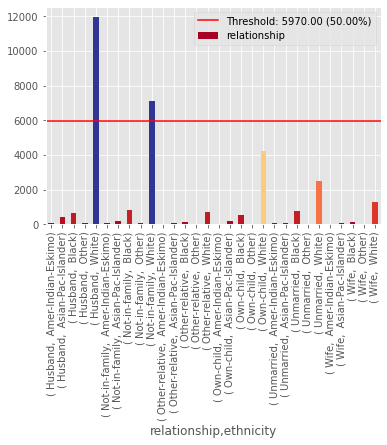

In [4]:
show_imbalance_selectmultiple = widgets.SelectMultiple(options=list(dataset.df.columns), rows=len(list(dataset.df.columns)) if len(list(dataset.df.columns)) <= 20 else 20, layout=Layout(width='auto', height='auto'))
show_imbalance_button = widgets.Button(description='Show imbalances', layout=Layout(width='auto', height='auto'), button_style='info', tooltip='Click me', icon='cubes')
correlations_matrix_button = Button(description='Correlations as a hierarchical dendogram', tooltip='Click me', icon='sitemap', layout=Layout(width='auto', height='auto'), disabled=False, style=ButtonStyle(button_color='darkseagreen'))
correlations_dendogram_button = Button(description='Correlations as a matrix', tooltip='Click me', icon='th-large', layout=Layout(width='auto', height='auto'), disabled=False, style=ButtonStyle(button_color='orange'))
show_imbalance_output = widgets.Output()

def on_click_show_imbalance_button(self):
    show_imbalance_output.clear_output()
    features_to_analyze = list(show_imbalance_selectmultiple.value)
    with show_imbalance_output:
        xai.imbalance_plot(dataset.df, *features_to_analyze)
        
def on_click_correlations_matrix_button(self):
    show_imbalance_output.clear_output()
    with show_imbalance_output:
        display(xai.correlations(dataset.df, include_categorical=True, plot_type="matrix"))
        
def on_click_correlations_dendogram_button(self):
    show_imbalance_output.clear_output()
    with show_imbalance_output:
        display(xai.correlations(dataset.df, include_categorical=True))

show_imbalance_button.on_click(on_click_show_imbalance_button)
correlations_matrix_button.on_click(on_click_correlations_matrix_button)
correlations_dendogram_button.on_click(on_click_correlations_dendogram_button)

grid_box = generate_analyze_grid(show_imbalance_selectmultiple,
                                 show_imbalance_button,
                                 correlations_dendogram_button,
                                 correlations_matrix_button)

display(grid_box, show_imbalance_output)

Select a target and the number of models to be trained, analyzed and compared.

In [5]:
target_dropdown = widgets.Dropdown(options=list(dataset.df.columns), value=None, disabled=False)
target_select_button = widgets.Button(description='Select target', disabled=False, button_style='success', tooltip='Click me', icon='mouse-pointer')
target_output = widgets.Output()

display(target_dropdown, target_select_button, target_output)

def on_value_change_target_dropdown(change):
    target_output.clear_output()
    df_target, msg = show_target(dataset.df, change['new'])
    with target_output:
        display(df_target)

def on_click_target_select_button(self):
    target_output.clear_output()
    global df_X, df_y
    df_X, df_y, msg = split_feature_target(dataset.df, target_dropdown.value)
    with target_output:
        display(msg)

target_dropdown.observe(on_value_change_target_dropdown, names='value')
target_select_button.on_click(on_click_target_select_button)

Dropdown(options=('age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relations…

Button(button_style='success', description='Select target', icon='mouse-pointer', style=ButtonStyle(), tooltip…

Output()

12-Jun-20 22:02:01 - Target 'loan' selected successfully.
13-Jun-20 15:18:21 - Target 'loan' selected successfully.


Train a model by selecting its properties. _Hover the mouse over the description of a property in order to get more information about it._

In [6]:
models_label = Label(layout=Layout(width='auto', height='auto'), value='Choose the number of models to be used: ')
models_slider = widgets.IntSlider(value=1, min=1, max=8, step=1, disabled=False, continuous_update=False, orientation='horizontal', readout=True, readout_format='d')
models_output = widgets.Output()

def draw_grid():
    display(generate_model_grid(
        df_X,
        number_of_models,
        models,
        on_click_feature_exclude_button=on_click_feature_exclude_button,
        on_value_change_split_type_dropdown=on_value_change_split_type_dropdown,
        on_click_model_train_button=on_click_model_train_button))

def on_value_change_models_slider(change):
    models_output.clear_output()
    global number_of_models, models
    number_of_models = change['new']
    models, _ = fill_empty_models(df_X, df_y, number_of_models)
    with models_output:
        draw_grid()

models_slider.observe(on_value_change_models_slider, names='value')
display(models_label, models_slider, models_output)

def on_value_change_split_type_dropdown(change):
    model = get_model_by_split_type_dd(models, change['owner'])
    _ = change_cross_columns_status(model, change['new'])

def on_click_feature_exclude_button(self):
    models_output.clear_output()
    model = get_model_by_remove_features_button(models, self)
    msg = remove_model_features(model)
    with models_output:
        draw_grid()

def on_click_model_train_button(self):
    model = get_model_by_train_model_button(models, self)
    msg = fill_model(model)
    with models_output:
        display(msg)

# initially show only one model
with models_output:
    number_of_models = 1
    models, _ = fill_empty_models(df_X, df_y, number_of_models)

    draw_grid()

Label(value='Choose the number of models to be used: ', layout=Layout(height='auto', width='auto'))

IntSlider(value=1, continuous_update=False, max=8, min=1)

Output()

GridBox(children=(Label(value='Choose a feature importance method', layout=Layout(height='auto', width='auto')…

Button(button_style='info', description='Generate feature importance plot(s)', icon='bullseye', layout=Layout(…

Output()

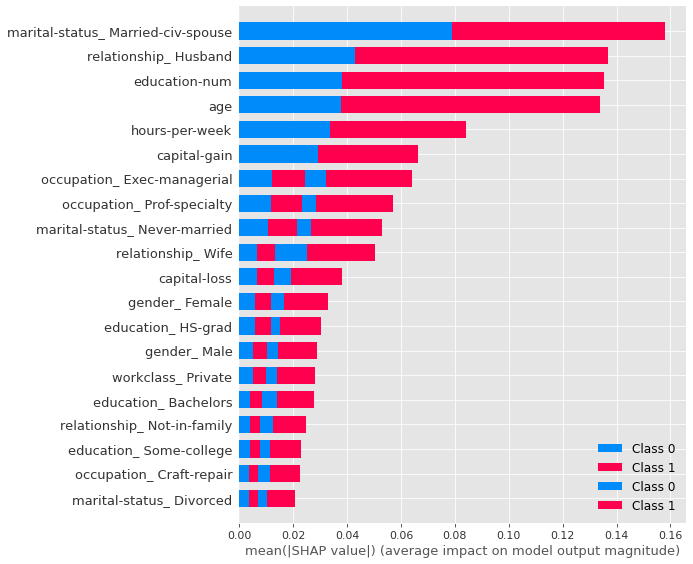

In [13]:
feature_importance_grid = generate_feature_importance_grid(models=models)
feature_importance_button = widgets.Button(description='Generate feature importance plot(s)', disabled=False, layout=Layout(width='auto', height='auto'), button_style='info', tooltip='Click me', icon='bullseye')
feature_importance_output = widgets.Output()

display(feature_importance_grid, feature_importance_button, feature_importance_output)

def on_click_feature_importance_button(self):
    feature_importance_output.clear_output()
    type_value = get_child_value_by_description(feature_importance_grid, "Type", 0)
    models_names = get_child_value_by_description(feature_importance_grid, "Model(s)", 0)
    selected_models = get_models_by_names(models, models_names)
    for model in selected_models:
        with feature_importance_output:
            plot = generate_feature_importance_plot(type_value, model)
            if plot:
                display(plot)

feature_importance_button.on_click(on_click_feature_importance_button)

The partial dependence plot (short PDP or PD plot) shows the marginal effect one or two features have on the predicted outcome of a machine learning model — J. H. Friedman

In [12]:
pdp_grid = generate_pdp_grid(models=models)
pdp_model_select_button = widgets.Button(description='Select model(s)', disabled=False, layout=Layout(width='auto', height='auto'), button_style='success', tooltip='Click me', icon='mouse-pointer')
pdp_output = widgets.Output()
# Inner output
pdp_feature_selection_grid = None
generate_pdp_plots_button = widgets.Button(description='Generate PDP plot(s)', disabled=False, layout=Layout(width='auto', height='auto'), button_style='info', tooltip='Click me', icon='bullseye')
generate_pdp_output = widgets.Output()

display(pdp_grid, pdp_model_select_button, pdp_output)

def on_click_pdp_model_select_button(self):
    pdp_output.clear_output()
    generate_pdp_output.clear_output()
    models_names = get_child_value_by_description(pdp_grid, "Model(s)", 0)
    global pdp_feature_selection_grid
    pdp_feature_selection_grid = generate_pdp_feature_selection_grid(get_models_by_names(models, models_names))
    with pdp_output:
        display(pdp_feature_selection_grid, generate_pdp_plots_button, generate_pdp_output)

def on_click_generate_pdp_plots_button(self):
    generate_pdp_output.clear_output()
    type_value = get_child_value_by_description(pdp_grid, "Type", 0)
    for model in models:
        feature1 = get_child_value_by_description(pdp_feature_selection_grid, "... " + model.name, 0)
        feature2 = get_child_value_by_description(pdp_feature_selection_grid, "... " + model.name, 1)
        with generate_pdp_output:
            generate_pdp_plots(type_value, model, feature1, feature2)    
        
pdp_model_select_button.on_click(on_click_pdp_model_select_button)
generate_pdp_plots_button.on_click(on_click_generate_pdp_plots_button)

GridBox(children=(Label(value='Choose a PDP method', layout=Layout(height='auto', width='auto')), Label(value=…

Button(button_style='success', description='Select model(s)', icon='mouse-pointer', layout=Layout(height='auto…

Output()

In [10]:
local_interpretation_grid = generate_local_interpretation_grid(models=models)
generate_local_interpretation_button = widgets.Button(description='Generate a Local Interpretation(s)', disabled=False, layout=Layout(width='auto', height='auto'), button_style='info', tooltip='Click me', icon='bullseye')
generate_local_interpretation_output = widgets.Output()

display(local_interpretation_grid, generate_local_interpretation_button, generate_local_interpretation_output)

def on_click_generate_local_interpretation_button(self):
    generate_local_interpretation_output.clear_output()
    type_value = get_child_value_by_description(local_interpretation_grid, "Type", 0)
    selected_models = get_models_by_names(models, get_child_value_by_description(local_interpretation_grid, "Model(s)", 0))
    examples_type_value = get_child_value_by_description(local_interpretation_grid, "Example(s) type:", 0)
    number_of_examples_value = get_child_value_by_description(local_interpretation_grid, "Number of examples:", 0)
    
    for model in selected_models:
        examples = get_test_examples(model, ExampleType[examples_type_value], number_of_examples_value)
        for example in examples:
            with generate_local_interpretation_output:
                explanation = explain_single_instance(model, LocalInterpreterType[type_value], example)
                if LocalInterpreterType[type_value] is LocalInterpreterType.LIME:
                    explanation.show_in_notebook(show_table=True, show_all=True)
                elif LocalInterpreterType[type_value] is LocalInterpreterType.SHAP:
                    display(explanation)
                
generate_local_interpretation_button.on_click(on_click_generate_local_interpretation_button)

GridBox(children=(Label(value='Choose an interpretation method', layout=Layout(height='auto', width='auto')), …

Button(button_style='info', description='Generate a Local Interpretation(s)', icon='bullseye', layout=Layout(h…

Output()

...